In [1]:
from IPython.display import clear_output
!pip install easyocr
clear_output()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 17.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyli

### Importing Pacakges

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Loading Images

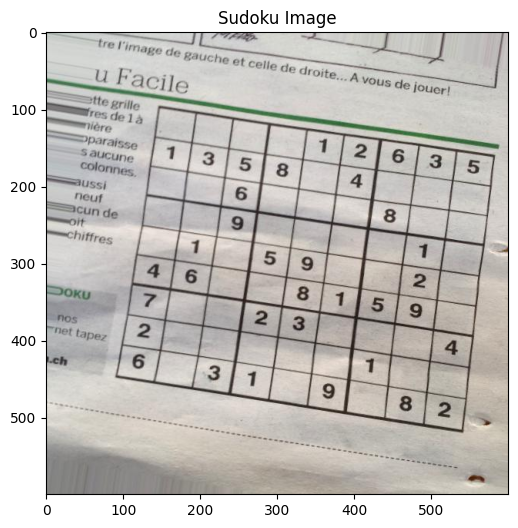

In [3]:
img = cv2.imread("sample_img.jpeg")
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Sudoku Image')
plt.show()

In [26]:
sudoku_a = cv2.resize(img, (450,450))
def preprocess(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3),6)
    #blur = cv2.bilateralFilter(gray,9,75,75)
    threshold_img = cv2.adaptiveThreshold(blur,255,1,1,11,2)
    return threshold_img

threshold = preprocess(sudoku_a)

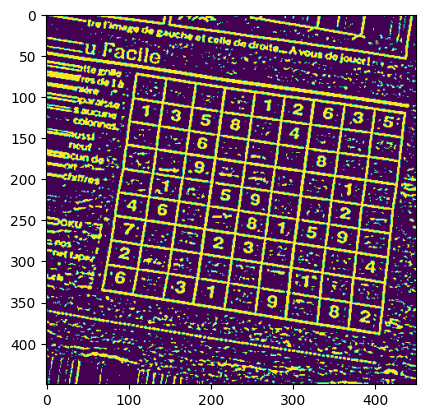

In [27]:
plt.imshow(threshold)

In [28]:
def main_outline(contour):
    biggest = np.array([])
    max_area = 0
    for i in contour:
        area = cv2.contourArea(i)
        if area >50:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i , 0.02* peri, True)
            if area > max_area and len(approx) ==4:
                biggest = approx
                max_area = area
    return biggest ,max_area

def reframe(points):
    points = points.reshape((4, 2))
    points_new = np.zeros((4,1,2),dtype = np.int32)
    add = points.sum(1)
    points_new[0] = points[np.argmin(add)]
    points_new[3] = points[np.argmax(add)]
    diff = np.diff(points, axis =1)
    points_new[1] = points[np.argmin(diff)]
    points_new[2] = points[np.argmax(diff)]
    return points_new

def splitcells(img):
    rows = np.vsplit(img,9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
    return boxes

array([[[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [191, 191, 197]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [195, 195, 201]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [190, 190, 196],
        [198, 198, 204]],

       ...,

       [[134, 136, 136],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [179, 191, 194],
        [179, 191, 195],
        [179, 191, 195]],

       [[133, 135, 135],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [184, 196, 200],
        [184, 196, 200],
        [184, 196, 200]],

       [[133, 135, 135],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [180, 192, 196],
        [180, 192, 196],
        [181, 193, 197]]], dtype=uint8)
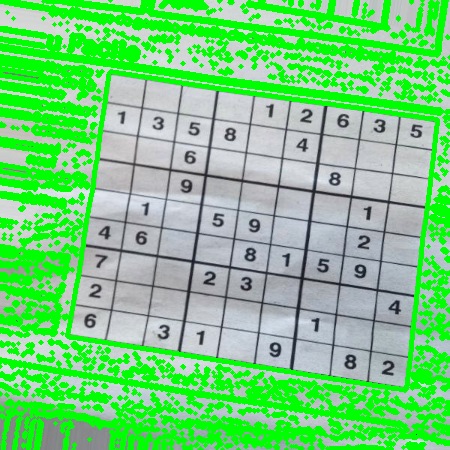

In [29]:
contour_1 = sudoku_a.copy()
contour_2 = sudoku_a.copy()
contour, hierarchy = cv2.findContours(threshold,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(contour_1, contour,-1,(0,255,0),3)

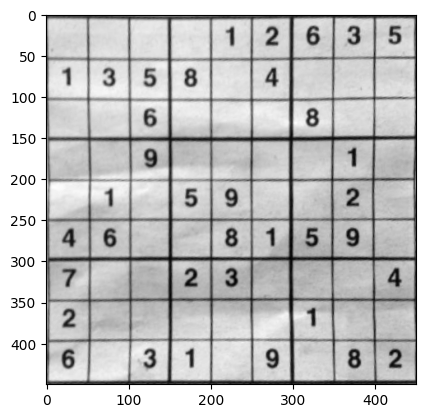

In [31]:
black_img = np.zeros((450,450,3), np.uint8)
biggest, maxArea = main_outline(contour)
if biggest.size != 0:
    biggest = reframe(biggest)
    cv2.drawContours(contour_2,biggest,-1, (0,255,0),10)
    pts1 = np.float32(biggest)
    pts2 = np.float32([[0,0],[450,0],[0,450],[450,450]])
    matrix = cv2.getPerspectiveTransform(pts1,pts2)
    imagewrap = cv2.warpPerspective(sudoku_a,matrix,(450,450))
    imagewrap =cv2.cvtColor(imagewrap, cv2.COLOR_BGR2GRAY)

plt.figure()
plt.imshow(imagewrap,cmap='gray')
plt.show()

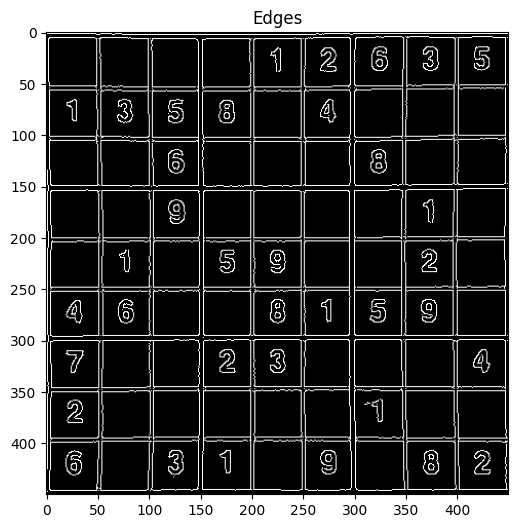

In [33]:
imagewrap_blur = cv2.GaussianBlur(imagewrap, (5, 5), 0)
edges = cv2.Canny(imagewrap_blur, 50, 100)

plt.figure(figsize=(8, 6))
plt.imshow(edges, cmap='gray')
plt.title('Edges')
plt.show()

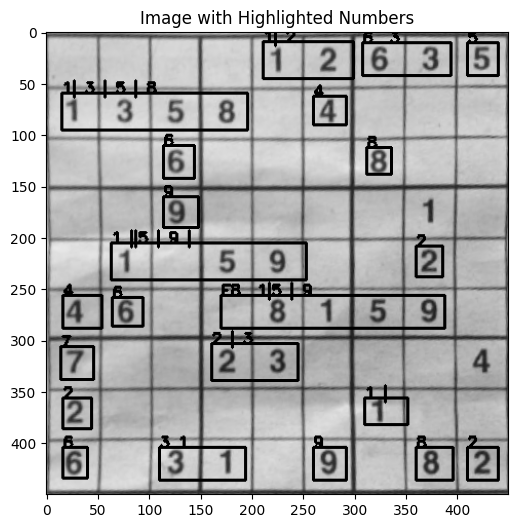

In [35]:
import easyocr
reader = easyocr.Reader(['en'])
result = reader.readtext(imagewrap_blur)

for detection in result:
    box = detection[0]
    text = detection[1]
    x1, y1 = box[0][0], box[0][1]
    x2, y2 = box[2][0], box[2][1]
    cv2.rectangle(imagewrap, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(imagewrap, text, (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(imagewrap, cv2.COLOR_BGR2RGB))
plt.title('Image with Highlighted Numbers')
plt.show()